In [1]:
import logging

import probtorch
import torch

import combinators
import importance
import mcmc
import ssm
import trace_tries
import utils

In [2]:
logging.basicConfig(format='%(asctime)s %(message)s', datefmt='%m/%d/%Y %H:%M:%S',
                    level=logging.INFO)

In [3]:
mu = torch.zeros(1)
sigma = torch.ones(1) / 2
delta = torch.ones(1)
zs = torch.ones(50+1) * -1
zs[0] = 0

In [4]:
ssm_step = combinators.PrimitiveCall(ssm.ssm_step)
ssm_initializer = combinators.ReturnModel(zs[0], mu, sigma, delta)
ssm_sequence = combinators.Reduce(ssm_step, generator=lambda: range(zs.shape[0]-1), initializer=ssm_initializer)

In [5]:
_, generative = ssm_sequence()

In [6]:
data = {k.rpartition('/')[-1]: rv.value for (k, rv) in generative.filter(lambda k, rv: 'X_' in k)}

In [7]:
particle_shape = (100,)

In [8]:
ssm_params = {
    'mu': {
        'loc': torch.tensor(0.),
        'scale': torch.tensor(0.25),
    },
    'sigma': {
        'loc': torch.tensor(1.),
        'scale': torch.tensor(0.25),
    },
    'delta': {
        'loc': torch.tensor(0.),
        'scale': torch.tensor(0.25),
    }
}

In [9]:
init_ssm_generative = combinators.HyperPopulation(ssm.init_ssm, particle_shape, hyper=ssm_params)
ssm_step_generative = combinators.PrimitiveCall(ssm.ssm_step)
ssm_generative = combinators.Reduce(ssm_step_generative, generator=lambda: range(50), initializer=init_ssm_generative)

In [10]:
init_ssm_proposal = combinators.HyperPopulation(ssm.init_ssm, particle_shape, trainable=ssm_params)
ssm_step_proposal = combinators.PrimitiveCall(ssm.ssm_step)
ssm_proposal = importance.smc(ssm_step_proposal, particle_shape, lambda: range(50), initializer=init_ssm_proposal)

In [11]:
ssm_score = combinators.score_under_proposal(ssm_proposal, ssm_generative)

In [12]:
inference, init_ssm_params, elbos = importance.variational_importance(
    ssm_score, 1000, data, use_cuda=False,
    lr=1e-2, patience=100
)

11/08/2018 19:36:35 ELBO=-6.50845718e+01 at epoch 1
11/08/2018 19:36:35 ELBO=-6.25686836e+01 at epoch 2
11/08/2018 19:36:35 ELBO=-6.51547394e+01 at epoch 3
11/08/2018 19:36:35 ELBO=-6.78956223e+01 at epoch 4
11/08/2018 19:36:35 ELBO=-6.36154213e+01 at epoch 5
11/08/2018 19:36:35 ELBO=-6.28555489e+01 at epoch 6
11/08/2018 19:36:35 ELBO=-6.63440781e+01 at epoch 7
11/08/2018 19:36:36 ELBO=-6.45708466e+01 at epoch 8
11/08/2018 19:36:36 ELBO=-6.55459213e+01 at epoch 9
11/08/2018 19:36:36 ELBO=-6.31949997e+01 at epoch 10
11/08/2018 19:36:36 ELBO=-6.41102829e+01 at epoch 11
11/08/2018 19:36:36 ELBO=-6.42508774e+01 at epoch 12
11/08/2018 19:36:36 ELBO=-6.52837601e+01 at epoch 13
11/08/2018 19:36:36 ELBO=-6.46568451e+01 at epoch 14
11/08/2018 19:36:37 ELBO=-6.50614548e+01 at epoch 15
11/08/2018 19:36:37 ELBO=-6.53366470e+01 at epoch 16
11/08/2018 19:36:37 ELBO=-6.14819450e+01 at epoch 17
11/08/2018 19:36:37 ELBO=-6.39303360e+01 at epoch 18
11/08/2018 19:36:37 ELBO=-6.37147942e+01 at epoch 19
11

Epoch   181: reducing learning rate of group 0 to 5.0000e-03.


11/08/2018 19:36:55 ELBO=-6.30524979e+01 at epoch 183
11/08/2018 19:36:56 ELBO=-6.23298225e+01 at epoch 184
11/08/2018 19:36:56 ELBO=-6.11556892e+01 at epoch 185
11/08/2018 19:36:56 ELBO=-6.29406090e+01 at epoch 186
11/08/2018 19:36:56 ELBO=-6.25463791e+01 at epoch 187
11/08/2018 19:36:56 ELBO=-6.30265579e+01 at epoch 188
11/08/2018 19:36:57 ELBO=-6.24783363e+01 at epoch 189
11/08/2018 19:36:57 ELBO=-6.23495293e+01 at epoch 190
11/08/2018 19:36:57 ELBO=-6.26776962e+01 at epoch 191
11/08/2018 19:36:57 ELBO=-6.33597794e+01 at epoch 192
11/08/2018 19:36:57 ELBO=-6.18241158e+01 at epoch 193
11/08/2018 19:36:58 ELBO=-6.05876732e+01 at epoch 194
11/08/2018 19:36:58 ELBO=-6.32204552e+01 at epoch 195
11/08/2018 19:36:58 ELBO=-6.36576233e+01 at epoch 196
11/08/2018 19:36:58 ELBO=-6.36532860e+01 at epoch 197
11/08/2018 19:36:58 ELBO=-6.40568542e+01 at epoch 198
11/08/2018 19:36:58 ELBO=-6.23419914e+01 at epoch 199
11/08/2018 19:36:58 ELBO=-6.37003021e+01 at epoch 200
11/08/2018 19:36:59 ELBO=-6.

Epoch   369: reducing learning rate of group 0 to 2.5000e-03.


11/08/2018 19:37:22 ELBO=-6.51758194e+01 at epoch 372
11/08/2018 19:37:22 ELBO=-6.36407280e+01 at epoch 373
11/08/2018 19:37:22 ELBO=-6.33545227e+01 at epoch 374
11/08/2018 19:37:22 ELBO=-6.13778114e+01 at epoch 375
11/08/2018 19:37:22 ELBO=-6.33293304e+01 at epoch 376
11/08/2018 19:37:23 ELBO=-6.29930878e+01 at epoch 377
11/08/2018 19:37:23 ELBO=-6.34546928e+01 at epoch 378
11/08/2018 19:37:23 ELBO=-6.34825325e+01 at epoch 379
11/08/2018 19:37:23 ELBO=-6.23494644e+01 at epoch 380
11/08/2018 19:37:23 ELBO=-6.51457825e+01 at epoch 381
11/08/2018 19:37:23 ELBO=-6.40483017e+01 at epoch 382
11/08/2018 19:37:23 ELBO=-6.46920700e+01 at epoch 383
11/08/2018 19:37:24 ELBO=-6.19813919e+01 at epoch 384
11/08/2018 19:37:24 ELBO=-6.38965492e+01 at epoch 385
11/08/2018 19:37:24 ELBO=-6.39990082e+01 at epoch 386
11/08/2018 19:37:24 ELBO=-6.44106522e+01 at epoch 387
11/08/2018 19:37:24 ELBO=-6.29985733e+01 at epoch 388
11/08/2018 19:37:24 ELBO=-6.48005829e+01 at epoch 389
11/08/2018 19:37:24 ELBO=-6.

Epoch   470: reducing learning rate of group 0 to 1.2500e-03.


11/08/2018 19:37:35 ELBO=-6.34053383e+01 at epoch 473
11/08/2018 19:37:35 ELBO=-6.32813072e+01 at epoch 474
11/08/2018 19:37:35 ELBO=-6.28624344e+01 at epoch 475
11/08/2018 19:37:35 ELBO=-6.43203201e+01 at epoch 476
11/08/2018 19:37:35 ELBO=-6.31863480e+01 at epoch 477
11/08/2018 19:37:35 ELBO=-6.35383186e+01 at epoch 478
11/08/2018 19:37:36 ELBO=-6.31432800e+01 at epoch 479
11/08/2018 19:37:36 ELBO=-6.28735466e+01 at epoch 480
11/08/2018 19:37:36 ELBO=-6.50303726e+01 at epoch 481
11/08/2018 19:37:36 ELBO=-6.19856415e+01 at epoch 482
11/08/2018 19:37:36 ELBO=-6.12506409e+01 at epoch 483
11/08/2018 19:37:36 ELBO=-6.43667450e+01 at epoch 484
11/08/2018 19:37:36 ELBO=-6.27239571e+01 at epoch 485
11/08/2018 19:37:36 ELBO=-6.15880203e+01 at epoch 486
11/08/2018 19:37:37 ELBO=-6.41332779e+01 at epoch 487
11/08/2018 19:37:37 ELBO=-6.20706940e+01 at epoch 488
11/08/2018 19:37:37 ELBO=-6.36912384e+01 at epoch 489
11/08/2018 19:37:37 ELBO=-6.50982056e+01 at epoch 490
11/08/2018 19:37:37 ELBO=-6.

Epoch   571: reducing learning rate of group 0 to 6.2500e-04.


11/08/2018 19:37:47 ELBO=-6.10287018e+01 at epoch 575
11/08/2018 19:37:47 ELBO=-6.62763367e+01 at epoch 576
11/08/2018 19:37:47 ELBO=-6.36339607e+01 at epoch 577
11/08/2018 19:37:47 ELBO=-6.47858276e+01 at epoch 578
11/08/2018 19:37:47 ELBO=-6.39494743e+01 at epoch 579
11/08/2018 19:37:48 ELBO=-6.40355759e+01 at epoch 580
11/08/2018 19:37:48 ELBO=-6.31357613e+01 at epoch 581
11/08/2018 19:37:48 ELBO=-6.36851273e+01 at epoch 582
11/08/2018 19:37:48 ELBO=-6.30862923e+01 at epoch 583
11/08/2018 19:37:48 ELBO=-6.41856308e+01 at epoch 584
11/08/2018 19:37:48 ELBO=-6.29178543e+01 at epoch 585
11/08/2018 19:37:48 ELBO=-6.40382233e+01 at epoch 586
11/08/2018 19:37:48 ELBO=-6.47565308e+01 at epoch 587
11/08/2018 19:37:48 ELBO=-6.05287781e+01 at epoch 588
11/08/2018 19:37:49 ELBO=-6.39848709e+01 at epoch 589
11/08/2018 19:37:49 ELBO=-6.25948143e+01 at epoch 590
11/08/2018 19:37:49 ELBO=-6.30574493e+01 at epoch 591
11/08/2018 19:37:49 ELBO=-6.28535728e+01 at epoch 592
11/08/2018 19:37:49 ELBO=-6.

Epoch   672: reducing learning rate of group 0 to 3.1250e-04.


11/08/2018 19:37:59 ELBO=-6.01383133e+01 at epoch 675
11/08/2018 19:37:59 ELBO=-6.28450241e+01 at epoch 676
11/08/2018 19:37:59 ELBO=-6.29794426e+01 at epoch 677
11/08/2018 19:38:00 ELBO=-6.26911430e+01 at epoch 678
11/08/2018 19:38:00 ELBO=-6.42315674e+01 at epoch 679
11/08/2018 19:38:00 ELBO=-6.46584549e+01 at epoch 680
11/08/2018 19:38:00 ELBO=-6.44460144e+01 at epoch 681
11/08/2018 19:38:00 ELBO=-6.40273514e+01 at epoch 682
11/08/2018 19:38:00 ELBO=-6.48411331e+01 at epoch 683
11/08/2018 19:38:00 ELBO=-6.38380699e+01 at epoch 684
11/08/2018 19:38:00 ELBO=-6.12662697e+01 at epoch 685
11/08/2018 19:38:00 ELBO=-6.09328194e+01 at epoch 686
11/08/2018 19:38:01 ELBO=-6.29267120e+01 at epoch 687
11/08/2018 19:38:01 ELBO=-6.27119713e+01 at epoch 688
11/08/2018 19:38:01 ELBO=-6.46319962e+01 at epoch 689
11/08/2018 19:38:01 ELBO=-6.26850433e+01 at epoch 690
11/08/2018 19:38:01 ELBO=-6.28510857e+01 at epoch 691
11/08/2018 19:38:01 ELBO=-6.32432709e+01 at epoch 692
11/08/2018 19:38:01 ELBO=-6.

Epoch   773: reducing learning rate of group 0 to 1.5625e-04.


11/08/2018 19:38:12 ELBO=-6.36295624e+01 at epoch 776
11/08/2018 19:38:12 ELBO=-6.30880508e+01 at epoch 777
11/08/2018 19:38:12 ELBO=-6.20563354e+01 at epoch 778
11/08/2018 19:38:12 ELBO=-6.37478828e+01 at epoch 779
11/08/2018 19:38:12 ELBO=-6.54980927e+01 at epoch 780
11/08/2018 19:38:12 ELBO=-6.18983536e+01 at epoch 781
11/08/2018 19:38:13 ELBO=-6.30265045e+01 at epoch 782
11/08/2018 19:38:13 ELBO=-6.05456238e+01 at epoch 783
11/08/2018 19:38:13 ELBO=-6.40716858e+01 at epoch 784
11/08/2018 19:38:13 ELBO=-6.46526642e+01 at epoch 785
11/08/2018 19:38:13 ELBO=-6.41390381e+01 at epoch 786
11/08/2018 19:38:13 ELBO=-6.44833984e+01 at epoch 787
11/08/2018 19:38:13 ELBO=-6.18924522e+01 at epoch 788
11/08/2018 19:38:13 ELBO=-6.47289658e+01 at epoch 789
11/08/2018 19:38:14 ELBO=-6.35002098e+01 at epoch 790
11/08/2018 19:38:14 ELBO=-6.32761879e+01 at epoch 791
11/08/2018 19:38:14 ELBO=-6.42349243e+01 at epoch 792
11/08/2018 19:38:14 ELBO=-6.57937012e+01 at epoch 793
11/08/2018 19:38:14 ELBO=-6.

Epoch   874: reducing learning rate of group 0 to 7.8125e-05.


11/08/2018 19:38:25 ELBO=-6.27418365e+01 at epoch 877
11/08/2018 19:38:25 ELBO=-6.45182648e+01 at epoch 878
11/08/2018 19:38:25 ELBO=-6.26222382e+01 at epoch 879
11/08/2018 19:38:25 ELBO=-6.39205627e+01 at epoch 880
11/08/2018 19:38:25 ELBO=-6.25092201e+01 at epoch 881
11/08/2018 19:38:25 ELBO=-6.14036713e+01 at epoch 882
11/08/2018 19:38:25 ELBO=-6.44289398e+01 at epoch 883
11/08/2018 19:38:25 ELBO=-6.37724686e+01 at epoch 884
11/08/2018 19:38:26 ELBO=-6.60302048e+01 at epoch 885
11/08/2018 19:38:26 ELBO=-6.37507133e+01 at epoch 886
11/08/2018 19:38:26 ELBO=-6.42972260e+01 at epoch 887
11/08/2018 19:38:26 ELBO=-6.28685341e+01 at epoch 888
11/08/2018 19:38:26 ELBO=-6.25765381e+01 at epoch 889
11/08/2018 19:38:26 ELBO=-6.24879456e+01 at epoch 890
11/08/2018 19:38:26 ELBO=-6.35426903e+01 at epoch 891
11/08/2018 19:38:27 ELBO=-6.32427216e+01 at epoch 892
11/08/2018 19:38:27 ELBO=-6.38501129e+01 at epoch 893
11/08/2018 19:38:27 ELBO=-6.31127014e+01 at epoch 894
11/08/2018 19:38:27 ELBO=-6.

Epoch   975: reducing learning rate of group 0 to 3.9063e-05.


11/08/2018 19:38:40 ELBO=-6.43213120e+01 at epoch 978
11/08/2018 19:38:40 ELBO=-6.24761086e+01 at epoch 979
11/08/2018 19:38:41 ELBO=-6.12770996e+01 at epoch 980
11/08/2018 19:38:41 ELBO=-6.32523117e+01 at epoch 981
11/08/2018 19:38:41 ELBO=-6.49840088e+01 at epoch 982
11/08/2018 19:38:41 ELBO=-6.33086090e+01 at epoch 983
11/08/2018 19:38:41 ELBO=-6.44839325e+01 at epoch 984
11/08/2018 19:38:41 ELBO=-6.17551193e+01 at epoch 985
11/08/2018 19:38:42 ELBO=-6.35869827e+01 at epoch 986
11/08/2018 19:38:42 ELBO=-6.38535500e+01 at epoch 987
11/08/2018 19:38:42 ELBO=-6.62022476e+01 at epoch 988
11/08/2018 19:38:42 ELBO=-6.26800499e+01 at epoch 989
11/08/2018 19:38:42 ELBO=-6.17365189e+01 at epoch 990
11/08/2018 19:38:42 ELBO=-6.34544029e+01 at epoch 991
11/08/2018 19:38:42 ELBO=-6.50836105e+01 at epoch 992
11/08/2018 19:38:42 ELBO=-6.26330986e+01 at epoch 993
11/08/2018 19:38:43 ELBO=-6.18950539e+01 at epoch 994
11/08/2018 19:38:43 ELBO=-6.44556198e+01 at epoch 995
11/08/2018 19:38:43 ELBO=-6.

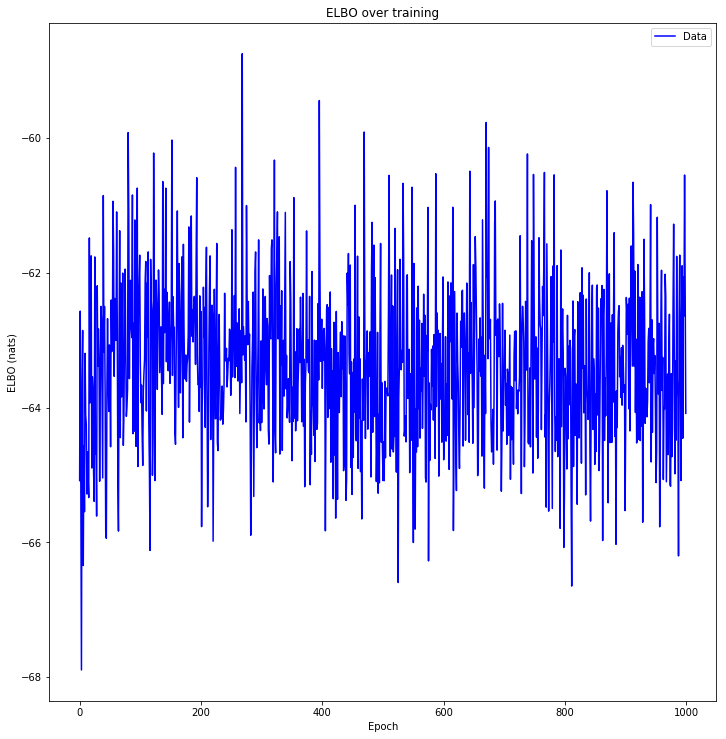

In [13]:
utils.plot_evidence_bounds(elbos)

In [14]:
for t in range(1, zs.shape[0]):
    key = generative.find(lambda k, v: ('Z_%d' % t) in k)[0]
    accuracy = ((inference[key].value - utils.optional_to(generative[key], inference[key].value))**2).mean()
    print('SMC MSE at time %d: %f' % (t, accuracy))

SMC MSE at time 1: 1.651993
SMC MSE at time 2: 1.503055
SMC MSE at time 3: 1.776070
SMC MSE at time 4: 2.716851
SMC MSE at time 5: 1.314338
SMC MSE at time 6: 1.438351
SMC MSE at time 7: 4.771574
SMC MSE at time 8: 1.192302
SMC MSE at time 9: 0.987042
SMC MSE at time 10: 0.774562
SMC MSE at time 11: 0.885661
SMC MSE at time 12: 1.011707
SMC MSE at time 13: 0.606604
SMC MSE at time 14: 0.610034
SMC MSE at time 15: 1.194386
SMC MSE at time 16: 0.794505
SMC MSE at time 17: 1.870654
SMC MSE at time 18: 1.956194
SMC MSE at time 19: 3.725725
SMC MSE at time 20: 4.032700
SMC MSE at time 21: 0.795745
SMC MSE at time 22: 4.313435
SMC MSE at time 23: 4.641104
SMC MSE at time 24: 4.085543
SMC MSE at time 25: 2.197882
SMC MSE at time 26: 0.770875
SMC MSE at time 27: 1.558029
SMC MSE at time 28: 0.780907
SMC MSE at time 29: 1.089603
SMC MSE at time 30: 1.229354
SMC MSE at time 31: 2.537811
SMC MSE at time 32: 2.611297
SMC MSE at time 33: 0.688543
SMC MSE at time 34: 0.512032
SMC MSE at time 35: 2.6

In [15]:
particle_mh = mcmc.IndependentMH(ssm_score, 1000)

In [16]:
lookup = utils.dict_lookup(data)
inference = trace_tries.HierarchicalTrace(observations=lookup)
samples, inference = particle_mh(trace=inference)

In [17]:
inference

In [18]:
generative